<a href="https://colab.research.google.com/github/YaoYuanxin/Laptop-Price-Prediction/blob/main/Laptop_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
The objective of this project is to tackle a regression problem: predicting the price of a laptop based on a variety of features.

We will construct predictive models using both classical machine learning techniques and deep learning methods. To assess model performance, we will utilize RMSE as the evaluation metric.

# Requirements

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns

# Explorative Data Analysis and Preprocessing

In [ ]:
train_df = pd.read_json('/content/drive/MyDrive/Data Projects/Laptop Prediction Project/datasets/train_dataset.json',orient = 'columns')
test_df = pd.read_json('/content/drive/MyDrive/Data Projects/Laptop Prediction Project/datasets/test_dataset.json',orient = 'columns')
val_df = pd.read_json('/content/drive/MyDrive/Data Projects/Laptop Prediction Project/datasets/val_dataset.json',orient = 'columns')

df = pd.concat([train_df, val_df, test_df], axis=0)
df.head(5)

,graphic card type,communications,resolution (px),CPU cores,RAM size,operating system,drive type,input devices,multimedia,RAM type,CPU clock speed (GHz),CPU model,state,drive memory size (GB),warranty,screen size,buynow_price
7233,dedicated graphics,"[bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,32 gb,[no system],ssd + hdd,"[keyboard, touchpad, illuminated keyboard, num...","[SD card reader, camera, speakers, microphone]",ddr4,2.6,intel core i7,new,1250.0,producer warranty,"17"" - 17.9""",4999.0
5845,dedicated graphics,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,8 gb,[windows 10 home],ssd,"[keyboard, touchpad, numeric keyboard]","[SD card reader, camera, speakers, microphone]",ddr3,2.4,intel core i7,new,256.0,seller warranty,"15"" - 15.9""",2649.0
10303,None,"[bluetooth, nfc (near field communication)]",1920 x 1080,2,8 gb,[windows 10 home],hdd,None,[SD card reader],ddr4,1.6,intel core i7,new,1000.0,producer warranty,"15"" - 15.9""",3399.0
10423,None,None,None,2,None,None,None,None,None,None,NaN,None,new,NaN,producer warranty,None,1599.0
5897,integrated graphics,"[wi-fi, bluetooth]",2560 x 1440,4,8 gb,[windows 10 home],ssd,"[keyboard, touchpad, illuminated keyboard]","[SD card reader, camera, speakers, microphone]",ddr4,1.2,other CPU,new,256.0,producer warranty,"12"" - 12.9""",4499.0


## Observe unique values of each column

In [ ]:
for col in df.columns.to_list():
    if type(df[col][0]) != list:
        print(f"unique values of {col} are: ", df[col].unique())
        print("-----------------------------------------------------")

unique values of graphic card type are:  ['dedicated graphics' None 'integrated graphics']
-----------------------------------------------------
unique values of resolution (px) are:  ['1920 x 1080' '1366 x 768' None '2560 x 1440' '1600 x 900' '3840 x 2160'
 'other' '1920 x 1280' '1280 x 800' '3200 x 1800' '2880 x 1620'
 '2160 x 1440' '1920 x 1200' '2560 x 1600']
-----------------------------------------------------
unique values of CPU cores are:  ['4' '2' 'not applicable' '3' '1' '8' '6']
-----------------------------------------------------
unique values of RAM size are:  ['32 gb' '8 gb' None '12 gb' '4 gb' '16 gb' '2 gb' '20 gb' '6 gb' '64 gb'
 '256 mb' '24 gb']
-----------------------------------------------------
unique values of drive type are:  ['ssd + hdd' 'ssd' 'hdd' None 'emmc' 'hybrid']
-----------------------------------------------------
unique values of RAM type are:  ['ddr4' 'ddr3' None 'ddr3l']
-----------------------------------------------------
unique values of CPU 

## Feature Preprocessing

### Remove null values and `state` column

In [ ]:
df = df.drop(columns=['state'])
df = df.dropna()

### `communication` column contains multiple attributes, split it into different columns

In [ ]:
compact_cols = ['communications', 'input devices', 'multimedia']
def get_unique_vals(col_name):
    #to_list function splits each comma separated value to a new column   
    col_df = pd.DataFrame(df[col_name].to_list())
    unique_vals = list()
    for col in col_df.columns.to_list():
        unique_vals += [val for val in list(col_df[col].unique()) if (val not in unique_vals and val is not None) ]

    return unique_vals

In [ ]:
compact_dict = {col: [] for  col in compact_cols}

# apply get_unique_vals to all compact_cols
# search through the dataframe and add a feature to unique_vals list when it is not included before
for col in compact_cols:
    compact_dict[col] = get_unique_vals(col)

In [ ]:
compact_dict

{'communications': ['bluetooth',
  'wi-fi',
  'wi-fi 802.11 b/g/n/ac',
  'lan 10/100 mbps',
  'wi-fi 802.11 a/b/g/n/ac',
  'nfc (near field communication)',
  'lan 10/100/1000 mbps',
  'gps',
  'wi-fi 802.11 b/g/n',
  'intel wireless display (widi)',
  'wi-fi 802.11 a/b/g/n',
  'modem 3g (wwan)',
  'modem 4g (lte)'],
 'input devices': ['keyboard',
  'touchpad',
  'illuminated keyboard',
  'numeric keyboard'],
 'multimedia': ['SD card reader', 'camera', 'microphone', 'speakers']}

### `RAM size` column

In [ ]:
# transform string value to integer by excluding gb and mb
df['RAM size'] = df['RAM size'].str.replace(' gb','',regex=True)

# when regex=False, replace requires exact match
df['RAM size'] = df['RAM size'].str.replace('256 mb','0.256',regex=False)

### `screen size` column

In [ ]:
df['screen size'] = df['screen size'].apply(lambda x: int(str(x)[:2]))

### `resolution` column

In [ ]:
df['resolution_x'] = df['resolution (px)'].apply(lambda x: x.split(' x ')[0]).astype(int)
df['resolution_y'] = df['resolution (px)'].apply(lambda x: x.split(' x ')[1]).astype(int)
df = df.drop(columns=['resolution (px)'])

### numerical columns

In [ ]:
numerical_cols = ['CPU cores', 'RAM size', 'CPU clock speed (GHz)','drive memory size (GB)', 'screen size', 'resolution_x', 'resolution_y']
numerical_df = df[numerical_cols].astype(float)

### use `get_dummies()` for categorical columns

In [ ]:
dummies_df = df['operating system'].str.join('|').str.get_dummies()

In [ ]:
dummy_cols = ['drive type', 'RAM type', 'CPU model']
for col in dummy_cols:
    col_dummies_df = df[col].str.get_dummies()
    dummies_df = pd.concat([dummies_df, col_dummies_df], axis=1)

In [ ]:
label_col = ['buynow_price']
categorical_columns = [col for col in df.columns.to_list() if col not in compact_cols + label_col + numerical_cols + ['operating system'] + dummy_cols]

In [ ]:
categorical_df = pd.get_dummies(df[categorical_columns])

In [ ]:
unique_cols = list()
for col in compact_cols:
    unique_cols += compact_dict[col]
compact_df = pd.DataFrame(columns = unique_cols , index=df.index, data=np.zeros((df.shape[0], len(unique_cols))))

In [ ]:
for col, unique_list in compact_dict.items():
    for unique in unique_list:
        compact_df[unique] = df[col].apply(lambda x: 1 if unique in x else 0)

## `new_df` now contains all the preprocessed columns

In [ ]:
new_df = pd.concat([categorical_df, numerical_df, compact_df, dummies_df],axis=1)
new_df.head(5)

,graphic card type_dedicated graphics,graphic card type_integrated graphics,warranty_producer warranty,warranty_seller warranty,CPU cores,RAM size,CPU clock speed (GHz),drive memory size (GB),screen size,resolution_x,...,intel celeron dual-core,intel celeron m,intel celeron quad core,intel core i3,intel core i5,intel core i7,intel core m,intel pentium dual-core,intel pentium quad-core,other CPU
7233,1,0,1,0,4.0,32.0,2.6,1250.0,17.0,1920.0,...,0,0,0,0,0,1,0,0,0,0
5845,1,0,0,1,4.0,8.0,2.4,256.0,15.0,1366.0,...,0,0,0,0,0,1,0,0,0,0
5897,0,1,1,0,4.0,8.0,1.2,256.0,12.0,2560.0,...,0,0,0,0,0,0,0,0,0,1
4870,0,1,1,0,2.0,8.0,2.0,1000.0,15.0,1366.0,...,0,0,0,1,0,0,0,0,0,0
2498,1,0,1,0,4.0,8.0,2.4,1000.0,17.0,1920.0,...,0,0,0,0,0,1,0,0,0,0


## Remove Multicollinearity 
Remove features with VIF(Variance Inflation Factor) score above 20

In [ ]:
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(new_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [ ]:
features = new_df.columns.to_list()
vif_data = compute_vif(features)

In [ ]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("Remove feature:", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()

Remove feature: other CPU


/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero 

Remove feature: graphic card type_dedicated graphics


/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero 

Remove feature: ssd


/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Remove feature: ddr3
Remove feature: warranty_producer warranty
Remove feature: resolution_x
Remove feature: touchpad
Remove feature: screen size
Remove feature: camera
Remove feature: CPU clock speed (GHz)
Remove feature: windows 10 home
Remove feature: keyboard
Remove feature: intel core i7
Remove feature: bluetooth
Remove feature: CPU cores
Remove feature: microphone


## Train Test Val split

In [ ]:
train_indeces = train_df.dropna().index
val_indeces = val_df.dropna().index
test_indeces = test_df.dropna().index

In [ ]:
train_df = new_df.loc[train_indeces]
val_df = new_df.loc[val_indeces]
test_df = new_df.loc[test_indeces]

X_train, X_val, X_test = train_df[selected_features].to_numpy(), val_df[selected_features].to_numpy(), test_df[selected_features].to_numpy()
y_train, y_val, y_test = df.loc[train_indeces][label_col].to_numpy().ravel(), df.loc[val_indeces][label_col].to_numpy().ravel(), df.loc[test_indeces][label_col].to_numpy().ravel()

In [ ]:
X_train.shape, y_train.shape

((3694, 52), (3694,))

# Traditional Machine Learning Models

Linear : 64038581464238.25
MLP : 719.6561002119159
DecisionTree : 656.6811883268169
RandomForest : 557.0123635130183
GradientBoosting : 526.9818640941238
ExtraTrees : 577.5740215020353


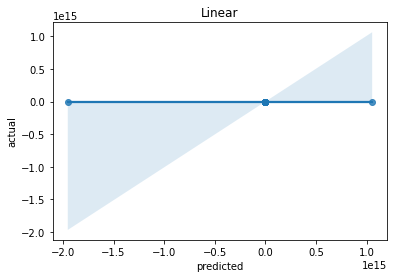

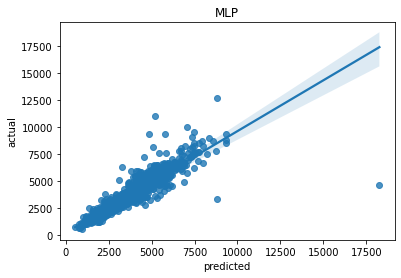

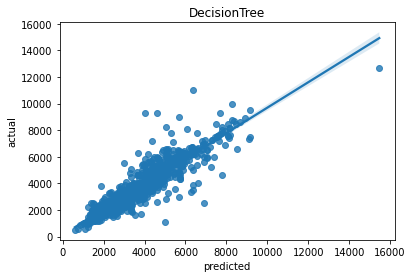

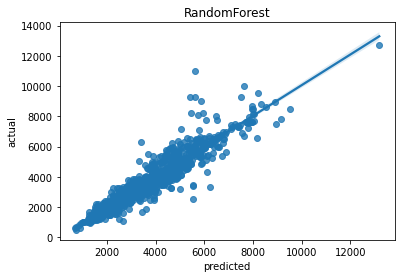

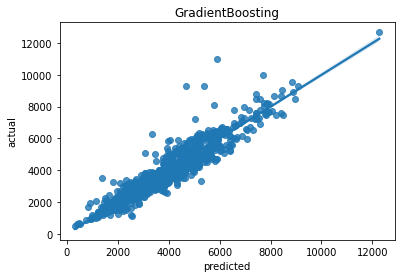

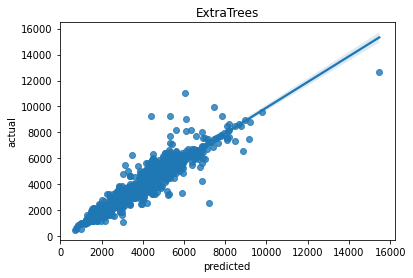

In [ ]:
def rmse(y_true, y_pred): 
    return mean_squared_error(y_true, y_pred, squared=False)


def regression(regressor_name, regressor):
#     alternative scaler 
#     pipe = make_pipeline(StandardScaler(), regressor)
    pipe = make_pipeline(MaxAbsScaler(), regressor)
    pipe.fit(X_train, y_train) 
    predicted = pipe.predict(X_test)
    rmse_val = rmse(y_test, predicted)
    print(regressor_name, ':', rmse_val)
    pred_df[regressor_name+'_Pred'] = predicted
    plt.figure(regressor_name)
    plt.title(regressor_name)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    sns.regplot(y=y_test,x=predicted)
    
regressors = {
    'Linear' : LinearRegression(),
    'MLP': MLPRegressor(random_state=42, max_iter=500, learning_rate="constant", learning_rate_init=0.6),
    'DecisionTree': DecisionTreeRegressor(max_depth=15, random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, criterion='squared_error',
                                                  loss='squared_error',learning_rate=0.6, warm_start=True),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
}

pred_df = pd.DataFrame(columns =["Actual"])
pred_df["Actual"] = y_test

for key in regressors.keys():
    regression(key, regressors[key])

# Voting Regressor

Voting : 504.99219187047


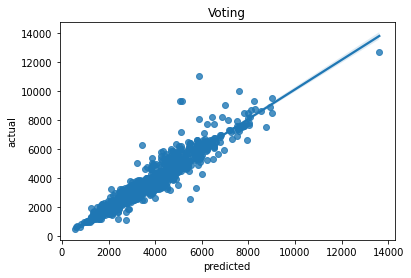

In [ ]:
from sklearn.ensemble import VotingRegressor

# classifiers
reg1 = regressors["GradientBoosting"]
reg2 = regressors["ExtraTrees"]
reg3 = regressors["RandomForest"]

# take the highest performed three models and combine them in a voting mechanism
# assign weights to their predictions and create new regressor
# it is possible to try with different weights 
regression("Voting", VotingRegressor([("gb", reg1), ("et", reg2), ("rf", reg3)], weights=[0.4, 0.35, 0.25]))